Import

In [1]:
import numpy as np
import pandas as pd

In [44]:
df_train = pd.read_csv("train.csv", index_col=False)
df_valid = pd.read_csv("valid.csv", index_col = False)
df_test = pd.read_csv("test.csv", index_col = False)

Reorder columns for model training

In [45]:
df_valid = df_valid.loc[:, df_train.columns]
df_test = df_test.loc[:, df_train.columns]

Split X/Y variables

In [46]:
y_train = df_train['FraudFound_P']
x_train = df_train.drop('FraudFound_P',axis = 1)
y_valid = df_valid['FraudFound_P']
x_valid = df_valid.drop('FraudFound_P',axis = 1)
y_test = df_test['FraudFound_P']
x_test = df_test.drop('FraudFound_P',axis = 1)

Oversampling and Undersampling

In [47]:
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

x_train, y_train = smote_enn.fit_resample(x_train, y_train)

In [6]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

### Tune For Recall

In [25]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 4012,
        class_weight = class_weight
        )
    return model

In [8]:
from sklearn.model_selection import cross_val_score, KFold
def model_performance(model, X = x_train, y = y_train):
    scores = cross_val_score(model, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=4012),
                             scoring="recall"
                            )
    # Return the mean of 10 scores
    return scores.mean()
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

In [9]:
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)

[I 2022-11-16 10:18:18,846] A new study created in memory with name: no-name-d6eeae0e-b1c0-414b-99b6-58f2d0fd8680
[I 2022-11-16 10:18:20,290] Trial 0 finished with value: 0.9417007442118583 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'zero_weight': 0.44048261198833927}. Best is trial 0 with value: 0.9417007442118583.
[I 2022-11-16 10:18:22,087] Trial 1 finished with value: 0.9580512381932333 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 7, 'zero_weight': 0.18656634058163424}. Best is trial 1 with value: 0.9580512381932333.
[I 2022-11-16 10:18:23,703] Trial 2 finished with value: 0.7958517712029126 and parameters: {'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 16, 'zero_weight': 0.8433148144329092}. Best is trial 1 with value: 0.9580512381932333.
[I 2022-11-16 10:18:25,495] Trial 3 finished with value: 0.9233152546334837 and parameters: {'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 7, '

In [10]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9957    0.4345    0.6050      2131
           1     0.0974    0.9701    0.1770       134

    accuracy                         0.4662      2265
   macro avg     0.5465    0.7023    0.3910      2265
weighted avg     0.9426    0.4662    0.5797      2265



In [12]:
print(study.best_params)

{'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 13, 'zero_weight': 0.005282477359577013}


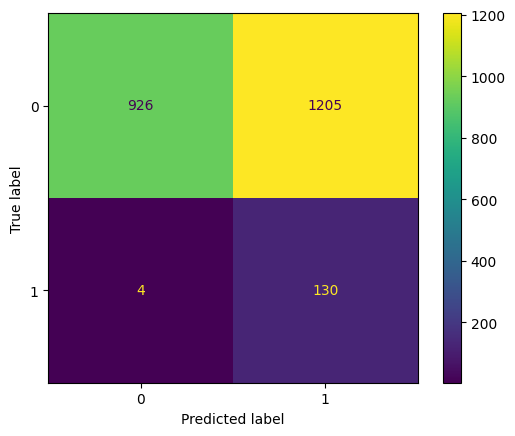

In [11]:
#Ploting the confusion matrix
cm=metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Tune For fbeta

In [13]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [26]:
def model_performance(model, X = x_train, y = y_train):
    scores = cross_val_score(model, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=4012),
                             scoring=ftwo_scorer
                            )
    # Return the mean of 10 scores
    return scores.mean()

def objective(trial):
    model = create_model(trial)
    return model_performance(model)

In [27]:
# %pip install optuna
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)


[I 2022-11-16 10:28:45,855] A new study created in memory with name: no-name-9fa6013a-1cdc-44ac-8d53-b4de2db67c46
[I 2022-11-16 10:28:47,483] Trial 0 finished with value: 0.9316611030583892 and parameters: {'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 13, 'zero_weight': 0.288741519946899}. Best is trial 0 with value: 0.9316611030583892.
[I 2022-11-16 10:28:48,665] Trial 1 finished with value: 0.6416612219132621 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 9, 'zero_weight': 0.9051179792774624}. Best is trial 0 with value: 0.9316611030583892.
[I 2022-11-16 10:28:50,184] Trial 2 finished with value: 0.9088825121394606 and parameters: {'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 12, 'zero_weight': 0.5170445168503455}. Best is trial 0 with value: 0.9316611030583892.
[I 2022-11-16 10:28:51,673] Trial 3 finished with value: 0.8862814838075636 and parameters: {'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 2, 'ze

In [28]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred, digits = 4))


              precision    recall  f1-score   support

           0     0.9661    0.7898    0.8691      2131
           1     0.1434    0.5597    0.2283       134

    accuracy                         0.7762      2265
   macro avg     0.5548    0.6747    0.5487      2265
weighted avg     0.9175    0.7762    0.8312      2265



In [49]:
clf2 = DecisionTreeClassifier(max_depth=6, min_samples_split=2, min_samples_leaf=13,class_weight={0:0.0053, 1: 0.9947})
clf2.fit(x_train,y_train)
y_pred = clf2.predict(x_valid)
print(fbeta_score(y_valid,y_pred, beta = 2))

0.347407803313736


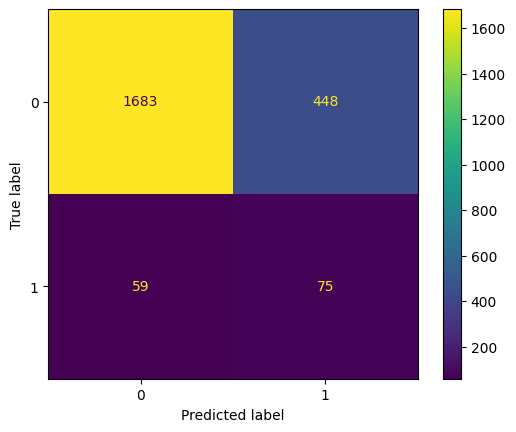

In [29]:
#Ploting the confusion matrix
cm=metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [30]:
study.best_params

{'max_depth': 12,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'zero_weight': 0.20308053704878326}

### Try feature selection

In [31]:
feature_impt = pd.DataFrame({'feature name':best_model.feature_names_in_, 'feature importance':best_model.feature_importances_})
not_impt = feature_impt.sort_values('feature importance').iloc[0:5,:]
print(not_impt)

              feature name  feature importance
26             Make_Jaguar                 0.0
38  MaritalStatus_Divorced                 0.0
35             Make_Saturn                 0.0
34               Make_Saab                 0.0
33             Make_Porche                 0.0


Variables
PolicyType_Sedan - Liability    0.365907
AddressChange_Claim             0.143410
Fault_IsPolicyholder            0.132279
MonthClaimed                    0.056226
Normalised_Age                  0.035064
Year                            0.028791
AgeOfVehicle                    0.022592
VehiclePrice                    0.020602
DriverRating                    0.018180
Deductible                      0.017734
Name: Importance, dtype: float64


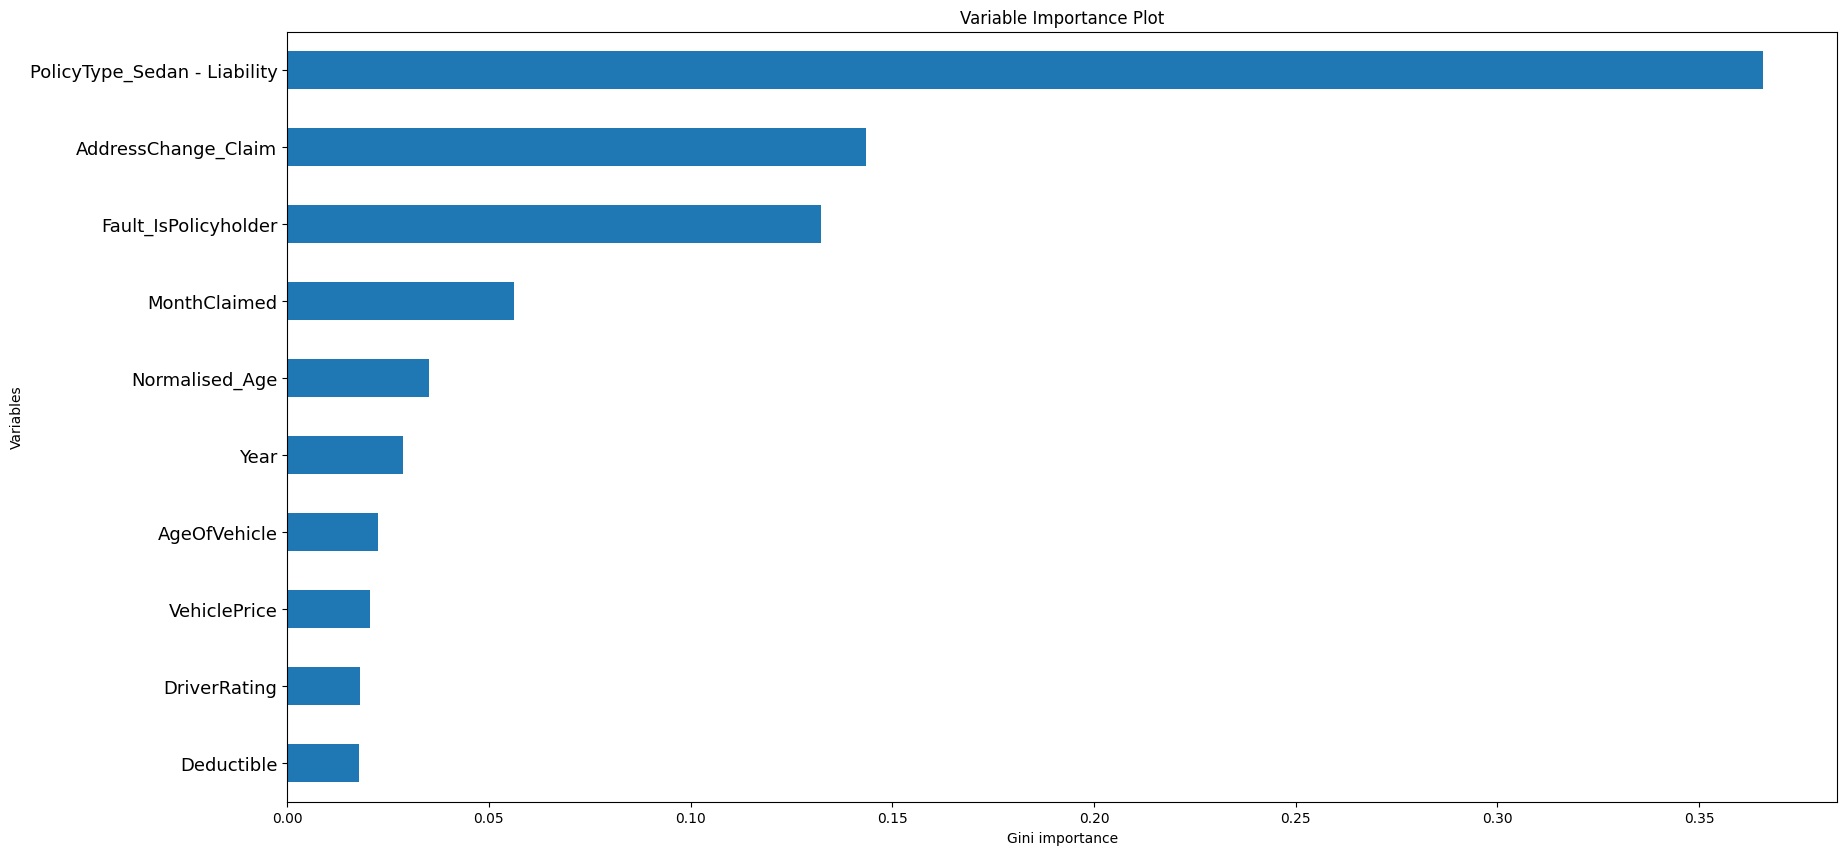

In [32]:
import matplotlib.pyplot as plt
model_ranks = pd.Series(best_model.feature_importances_, index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:10].sort_values(ascending=True, inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
ax.set_title('Variable Importance Plot')
ax.set_xlabel('Gini importance')
ax.set_yticklabels(top_features.index, fontsize=13)

print(top_features.sort_values(ascending=False))

In [33]:
# remove feature importance == 0
not_impt['feature name']
x_train = x_train.drop(not_impt['feature name'], axis = 1)
x_valid = x_valid.drop(not_impt['feature name'], axis = 1)
x_test = x_test.drop(not_impt['feature name'], axis = 1)

In [17]:
x_train

,MonthClaimed,VehiclePrice,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,...,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,Make_Ferrari,PolicyType_Sport - Liability,Normalised_Age
0,2.000000,1.000000,1.0,1.000000,4.0,2.0,0.000000,6.000000,5.000000,3.000000,...,0,0,0,0,0,0,0,0,0,0.427219
1,5.000000,1.000000,1.0,1.000000,4.0,2.0,3.000000,5.000000,3.000000,3.000000,...,0,1,0,0,0,0,0,0,0,-0.546320
2,4.000000,1.000000,1.0,0.000000,4.0,2.0,2.000000,6.000000,3.000000,0.000000,...,0,1,0,0,0,0,0,0,0,-0.789705
3,0.000000,5.000000,1.0,0.000000,4.0,2.0,2.000000,4.000000,3.000000,1.000000,...,0,1,0,0,0,0,0,0,0,-0.870833
4,11.000000,1.000000,1.0,0.000000,4.0,2.0,3.000000,5.000000,3.000000,0.000000,...,0,1,0,0,0,0,0,0,0,-0.708577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12526,3.930081,1.000000,1.0,0.069919,4.0,2.0,1.000000,6.000000,4.000000,0.930081,...,0,0,0,0,0,0,0,0,0,-0.199118
12527,5.000000,1.000000,1.0,2.888695,4.0,2.0,0.000000,2.166958,2.000000,0.055653,...,0,0,0,0,0,0,0,0,0,-1.276475
12528,4.000000,1.000000,1.0,3.000000,4.0,2.0,1.637323,5.637323,3.637323,3.000000,...,0,0,0,0,0,0,0,0,0,-0.501757
12529,3.939469,2.060531,1.0,2.060531,4.0,2.0,1.060531,6.060531,5.939469,1.939469,...,1,0,0,0,0,0,0,0,0,1.209037


In [34]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 4012,
        class_weight = class_weight
        )
    return model
def model_performance(model, X = x_train, y = y_train):
    scores = cross_val_score(model, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=4012),
                             scoring=ftwo_scorer
                            )
    # Return the mean of 10 scores
    return scores.mean()

def objective(trial):
    model = create_model(trial)
    return model_performance(model)

In [35]:
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100, timeout = 600)

[I 2022-11-16 10:31:29,879] A new study created in memory with name: no-name-e01c202c-10e1-4aa2-9582-a259b1e4e2db
[I 2022-11-16 10:31:31,720] Trial 0 finished with value: 0.9265812524509842 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 18, 'zero_weight': 0.3255717922476222}. Best is trial 0 with value: 0.9265812524509842.
[I 2022-11-16 10:31:33,255] Trial 1 finished with value: 0.9371490849137588 and parameters: {'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 10, 'zero_weight': 0.229981101469928}. Best is trial 1 with value: 0.9371490849137588.
[I 2022-11-16 10:31:34,389] Trial 2 finished with value: 0.5579860236571977 and parameters: {'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 2, 'zero_weight': 0.795327401345013}. Best is trial 1 with value: 0.9371490849137588.
[I 2022-11-16 10:31:35,854] Trial 3 finished with value: 0.9370125367133456 and parameters: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 6, 'zero_

In [36]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9692    0.7522    0.8470      2131
           1     0.1358    0.6194    0.2228       134

    accuracy                         0.7444      2265
   macro avg     0.5525    0.6858    0.5349      2265
weighted avg     0.9199    0.7444    0.8101      2265



A slight improvement in precision after feature selection